# Missing Values Handling

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

base_dir = os.path.join(os.getcwd(), os.pardir)

Load in the data

In [2]:
data_path = os.path.join(base_dir, "data/altered/maps-feature-mapping.csv")
df = pd.read_csv(data_path, index_col="X")

print(f"{df.shape[1]} features, {df.shape[0]} entries")
df.head()

82 features, 13734 entries


,comp_bed_9,mat_dep,mat_age,weight_16,height_16,iq,comp_noint_bed_16,comp_int_bed_16,talk_phon_wend,text_wend,...,dep_score,comp_house,tv_bed_16,creat_14,comp_games,fam_tv_eve,fam_tv_aft,fam_tv_mor,sex,birth_order
X,,,,,,,,,,,,,,,,,,,,,
1,NaN,3.0,30.0,59.294132,181.602831,107.0,NaN,NaN,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0
2,NaN,9.0,26.0,NaN,NaN,85.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
3,NaN,3.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,2.0,0.0,1.0,0.0
4,0.0,NaN,22.0,49.812426,160.224186,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,0.0
5,0.0,8.0,31.0,62.270030,191.703227,132.0,1.0,NaN,0.0,0.0,...,NaN,NaN,NaN,1.0,0.0,1.0,2.0,2.0,0.0,0.0


## NaN Analysis

Lets see how many data entries are missing.

In [3]:
total_count = df.size
total_na_count = df.isna().sum().sum()
print(f"Total missing entries: {total_na_count} / {total_count} ({100*total_na_count/total_count:.2f}%)")

Total missing entries: 563352 / 1126188 (50.02%)


We can also check this per feature.

In [6]:
na_counts = df.isna().sum().sort_values(ascending=False).copy()
counts_df = pd.DataFrame(features, columns=['feature'])
counts_df['na_count'] = na_counts.values
counts_df['percentage_missing'] = 100 * counts_df.na_count / len(df)
counts_df

for i, count in counts_df.iterrows():
    print(f"{count.feature}: {count.percentage_missing:.2f}%")

comp_bed_9: 96.57%
mat_dep: 94.81%
mat_age: 86.86%
weight_16: 81.29%
height_16: 71.77%
iq: 68.06%
comp_noint_bed_16: 67.14%
comp_int_bed_16: 67.14%
talk_phon_wend: 67.14%
text_wend: 67.14%
talk_mob_wend: 67.14%
comp_wend: 64.89%
musi_wend: 64.82%
read_wend: 64.81%
work_wend: 64.80%
alon_wend: 64.80%
draw_wend: 64.77%
play_wend: 64.75%
tv_wend: 64.74%
out_win_wend: 64.69%
out_sum_wend: 64.69%
tran_wend: 64.69%
talk_phon_week: 64.69%
text_week: 64.66%
talk_mob_week: 64.61%
comp_week: 63.81%
musi_week: 63.67%
read_week: 63.64%
work_week: 63.60%
alon_week: 63.57%
draw_week: 63.56%
play_week: 63.54%
tv_week: 63.54%
out_win_week: 63.51%
out_sum_week: 63.51%
tran_week: 63.51%
pat_pres_10: 63.49%
pat_pres_8: 63.48%
pat_pres: 63.48%
num_home: 63.45%
mat_anx_1: 63.42%
mat_anx_18m: 61.42%
mat_anx_8m: 61.39%
agg_score: 61.04%
emot_cruel: 60.94%
phys_cruel: 56.59%
mat_anx_0m: 55.36%
pat_ses: 49.91%
mat_ses: 49.01%
pat_edu: 48.35%
mat_edu: 47.88%
parity: 46.93%
dep_band_15: 44.09%
dep_band_13: 43.72

Lets get the fully complete features.

In [8]:
# print(f"number of features with missing entries: {na_col_count} of {df.shape[1]} total features ({100*na_col_count/df.shape[1]:.0f}%).")
print("\nfully complete features:\n")
for na_count, feature in zip(na_counts, features):
    if na_count == 0:
        print(f"\t- {feature}")


fully complete features:

	- sex
	- birth_order


Apart from `sex` and `birth_order` it seems most of the features have missing entries.

Lets visualise the percentage missing from features in a histogram.

Below is a histogram showing the distribution of the percentage of missing entries from features.

<AxesSubplot:>

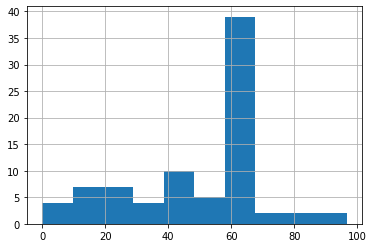

In [9]:
counts_df.percentage_missing.hist()

_what does it mean_

We can also do the same for the entries themselves. Below is a histogram showing the distribution of the percentage of missing features from entries.

<AxesSubplot:>

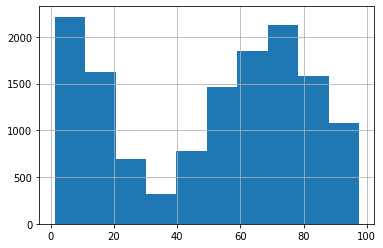

In [11]:
na_entries = df.isna().sum(axis=1)
na_entries_df = pd.DataFrame(na_entries, columns=['missing_feature_entries'])
na_entries_df['percentage_missing_feature_entries'] = 100 * na_entries_df.missing_feature_entries / len(features)
na_entries_df.percentage_missing_feature_entries.hist()

_what does it mean_

---

## Missing Value Handling

From the above analysis of the NaN values we can see a lot of entries are missing from the data set.

To use this dataset with a wider range of methods it would be useful if all data points were filled in. 

We are unable to gather the real data for these missing entries, but we can use methods of imputation to fill them in with values that fit the datasets current distribution.

In [12]:
# add missing value imputation